In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split
import sys, os
sys.path.append(os.path.abspath('..'))
from pre_processamento.processamento_dados import processamento

In [3]:
df = processamento()

Divisão entre treino, validação e teste para evitar dataleak

In [30]:
# Gerar colunas 'hora' e 'mes' a partir do índice datetime
df['hora'] = df.index.hour
df['mes'] = df.index.month

# --- Termos de Fourier para periodicidade horária (período = 24 horas) ---
def add_fourier_terms(df, period_hours=24, n_harmonics=3, prefix='fourier'):
    """Adiciona colunas sin/cos para os n_harmonics primeiros harmônicos.
    Usa horas desde o primeiro timestamp como base de tempo."""
    t = (df.index - df.index[0]).total_seconds() / 3600.0
    t = np.asarray(t)
    for k in range(1, n_harmonics + 1):
        df[f'{prefix}_{k}_sin'] = np.sin(2 * np.pi * k * t / period_hours)
        df[f'{prefix}_{k}_cos'] = np.cos(2 * np.pi * k * t / period_hours)
    return df

# Adiciona 3 harmônicos por padrão (pode ajustar se necessário)
df = add_fourier_terms(df, period_hours=24, n_harmonics=3)

# Lista de colunas de Fourier criadas
fourier_cols = [c for c in df.columns if c.startswith('fourier_')]

#Adiciona os 3 lags no df para depois fazer a divisão
df['lag_1'] = df['TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)'].shift(1)
df['lag_2'] = df['TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)'].shift(2)
df['lag_3'] = df['TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)'].shift(3)
df.dropna(inplace=True)

feature_cols = ['hora', 'mes', 'lag_1', 'lag_2', 'lag_3', 'TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)'] + fourier_cols
# --- Criar conjuntos de treino / validação / teste (por períodos) ---
# Período de treino (2010)
train_end = '2010-12-31 23:00:00'
df_train = df[feature_cols].loc[:train_end]
# Período de validação (2011)
val_end = '2011-12-31 23:00:00'
val_start = '2011-01-01 00:00:00'
df_val = df[feature_cols].loc[val_start:val_end]

# Período de teste (2012)
test_start = '2012-01-01 00:00:00'
df_test = df[feature_cols].loc[test_start:]

Visão geral das propriedades da série

In [31]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8757 entries, 2010-01-01 03:00:00 to 2010-12-31 23:00:00
Data columns (total 12 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   hora                                        8757 non-null   int32  
 1   mes                                         8757 non-null   int32  
 2   lag_1                                       8757 non-null   float64
 3   lag_2                                       8757 non-null   float64
 4   lag_3                                       8757 non-null   float64
 5   TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)  8757 non-null   float64
 6   fourier_1_sin                               8757 non-null   float64
 7   fourier_1_cos                               8757 non-null   float64
 8   fourier_2_sin                               8757 non-null   float64
 9   fourier_2_cos                               8757 

# Modelagem

Para modelagem iremos usar o modelo SARIMAX, pois iremos usar variáveis exógenas para poder auxiliar o modelo, que serão os lags 1, 2, 3, que correspondem aos valores da variável que estamos buscando a 1, 2, 3 observações anteriores

Após definir os lags basta definir os parâmetros que iremos utilizar no SARIMAX, para isso iremos rodar um grid search para os parâmetros p, q, P, Q, pois o d e D já sabemos que é 0, porque não precisamos diferenciar a parte não sazonal, mas necessitamos de uma diferenciação sazonal, o que torna D = 1 e sazonalidade é 24.

In [7]:
from statsmodels.tsa.arima.model import ARIMA
import itertools

In [14]:
p = range(0, 2)
q = range(0, 2)
Q = range(0, 2)
P = range(0, 2)
params = list(itertools.product(p, q, Q, P))
lags = [df_train['lag_1'], df_train[['lag_1', 'lag_2']], df_train[['lag_1', 'lag_2', 'lag_3']]]
results = []
for param in params:
  for lag in lags:
      model = ARIMA(df_train['TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)'], order=(param[0], 0, param[1]), seasonal_order=(param[2], 1, param[3], 24), exog=lag, enforce_invertibility=False, enforce_stationarity=False)
      model_fit = model.fit()
      if lag.ndim == 1:
          lag_name = 'lag_1'
      else:
          lag_name = '_'.join(lag.columns)
      print(f"Treinamento feito com os parâmetros: {param} e {lag_name}. Resultado AIC: {model_fit.aic}")
      results.append((param, model_fit.aic, lag_name))



c:\Users\Eduardo\Documents\Trabalho-de-Aprendizado-de-Maquina-e-Ciencia-de-Dados\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\Eduardo\Documents\Trabalho-de-Aprendizado-de-Maquina-e-Ciencia-de-Dados\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\Eduardo\Documents\Trabalho-de-Aprendizado-de-Maquina-e-Ciencia-de-Dados\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


Treinamento feito com os parâmetros: (0, 0, 0, 0) e lag_1. Resultado AIC: 23710.08711397287


c:\Users\Eduardo\Documents\Trabalho-de-Aprendizado-de-Maquina-e-Ciencia-de-Dados\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\Eduardo\Documents\Trabalho-de-Aprendizado-de-Maquina-e-Ciencia-de-Dados\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\Eduardo\Documents\Trabalho-de-Aprendizado-de-Maquina-e-Ciencia-de-Dados\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


Treinamento feito com os parâmetros: (0, 0, 0, 0) e lag_1_lag_2. Resultado AIC: 23090.630137293167


c:\Users\Eduardo\Documents\Trabalho-de-Aprendizado-de-Maquina-e-Ciencia-de-Dados\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\Eduardo\Documents\Trabalho-de-Aprendizado-de-Maquina-e-Ciencia-de-Dados\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\Eduardo\Documents\Trabalho-de-Aprendizado-de-Maquina-e-Ciencia-de-Dados\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


Treinamento feito com os parâmetros: (0, 0, 0, 0) e lag_1_lag_2_lag_3. Resultado AIC: 23081.5191954798


c:\Users\Eduardo\Documents\Trabalho-de-Aprendizado-de-Maquina-e-Ciencia-de-Dados\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\Eduardo\Documents\Trabalho-de-Aprendizado-de-Maquina-e-Ciencia-de-Dados\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\Eduardo\Documents\Trabalho-de-Aprendizado-de-Maquina-e-Ciencia-de-Dados\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


Treinamento feito com os parâmetros: (0, 0, 0, 1) e lag_1. Resultado AIC: 19208.00768649485


c:\Users\Eduardo\Documents\Trabalho-de-Aprendizado-de-Maquina-e-Ciencia-de-Dados\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\Eduardo\Documents\Trabalho-de-Aprendizado-de-Maquina-e-Ciencia-de-Dados\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\Eduardo\Documents\Trabalho-de-Aprendizado-de-Maquina-e-Ciencia-de-Dados\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


Treinamento feito com os parâmetros: (0, 0, 0, 1) e lag_1_lag_2. Resultado AIC: 18308.3301276406


c:\Users\Eduardo\Documents\Trabalho-de-Aprendizado-de-Maquina-e-Ciencia-de-Dados\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\Eduardo\Documents\Trabalho-de-Aprendizado-de-Maquina-e-Ciencia-de-Dados\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\Eduardo\Documents\Trabalho-de-Aprendizado-de-Maquina-e-Ciencia-de-Dados\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


Treinamento feito com os parâmetros: (0, 0, 0, 1) e lag_1_lag_2_lag_3. Resultado AIC: 18303.65854308431


c:\Users\Eduardo\Documents\Trabalho-de-Aprendizado-de-Maquina-e-Ciencia-de-Dados\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\Eduardo\Documents\Trabalho-de-Aprendizado-de-Maquina-e-Ciencia-de-Dados\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\Eduardo\Documents\Trabalho-de-Aprendizado-de-Maquina-e-Ciencia-de-Dados\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


Treinamento feito com os parâmetros: (0, 0, 1, 0) e lag_1. Resultado AIC: 21725.875806203534


c:\Users\Eduardo\Documents\Trabalho-de-Aprendizado-de-Maquina-e-Ciencia-de-Dados\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\Eduardo\Documents\Trabalho-de-Aprendizado-de-Maquina-e-Ciencia-de-Dados\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\Eduardo\Documents\Trabalho-de-Aprendizado-de-Maquina-e-Ciencia-de-Dados\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


Treinamento feito com os parâmetros: (0, 0, 1, 0) e lag_1_lag_2. Resultado AIC: 20942.993648102696


c:\Users\Eduardo\Documents\Trabalho-de-Aprendizado-de-Maquina-e-Ciencia-de-Dados\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\Eduardo\Documents\Trabalho-de-Aprendizado-de-Maquina-e-Ciencia-de-Dados\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\Eduardo\Documents\Trabalho-de-Aprendizado-de-Maquina-e-Ciencia-de-Dados\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


Treinamento feito com os parâmetros: (0, 0, 1, 0) e lag_1_lag_2_lag_3. Resultado AIC: 20936.891138044808


c:\Users\Eduardo\Documents\Trabalho-de-Aprendizado-de-Maquina-e-Ciencia-de-Dados\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\Eduardo\Documents\Trabalho-de-Aprendizado-de-Maquina-e-Ciencia-de-Dados\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\Eduardo\Documents\Trabalho-de-Aprendizado-de-Maquina-e-Ciencia-de-Dados\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


Treinamento feito com os parâmetros: (0, 0, 1, 1) e lag_1. Resultado AIC: 19110.787335344707


c:\Users\Eduardo\Documents\Trabalho-de-Aprendizado-de-Maquina-e-Ciencia-de-Dados\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\Eduardo\Documents\Trabalho-de-Aprendizado-de-Maquina-e-Ciencia-de-Dados\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\Eduardo\Documents\Trabalho-de-Aprendizado-de-Maquina-e-Ciencia-de-Dados\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


Treinamento feito com os parâmetros: (0, 0, 1, 1) e lag_1_lag_2. Resultado AIC: 18275.404130776456


c:\Users\Eduardo\Documents\Trabalho-de-Aprendizado-de-Maquina-e-Ciencia-de-Dados\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\Eduardo\Documents\Trabalho-de-Aprendizado-de-Maquina-e-Ciencia-de-Dados\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\Eduardo\Documents\Trabalho-de-Aprendizado-de-Maquina-e-Ciencia-de-Dados\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


Treinamento feito com os parâmetros: (0, 0, 1, 1) e lag_1_lag_2_lag_3. Resultado AIC: 18271.033724890855


c:\Users\Eduardo\Documents\Trabalho-de-Aprendizado-de-Maquina-e-Ciencia-de-Dados\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\Eduardo\Documents\Trabalho-de-Aprendizado-de-Maquina-e-Ciencia-de-Dados\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\Eduardo\Documents\Trabalho-de-Aprendizado-de-Maquina-e-Ciencia-de-Dados\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


Treinamento feito com os parâmetros: (0, 1, 0, 0) e lag_1. Resultado AIC: 23159.94302308373


c:\Users\Eduardo\Documents\Trabalho-de-Aprendizado-de-Maquina-e-Ciencia-de-Dados\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\Eduardo\Documents\Trabalho-de-Aprendizado-de-Maquina-e-Ciencia-de-Dados\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\Eduardo\Documents\Trabalho-de-Aprendizado-de-Maquina-e-Ciencia-de-Dados\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


Treinamento feito com os parâmetros: (0, 1, 0, 0) e lag_1_lag_2. Resultado AIC: 23075.86809651174


c:\Users\Eduardo\Documents\Trabalho-de-Aprendizado-de-Maquina-e-Ciencia-de-Dados\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\Eduardo\Documents\Trabalho-de-Aprendizado-de-Maquina-e-Ciencia-de-Dados\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\Eduardo\Documents\Trabalho-de-Aprendizado-de-Maquina-e-Ciencia-de-Dados\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


Treinamento feito com os parâmetros: (0, 1, 0, 0) e lag_1_lag_2_lag_3. Resultado AIC: 23068.473884378916


c:\Users\Eduardo\Documents\Trabalho-de-Aprendizado-de-Maquina-e-Ciencia-de-Dados\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\Eduardo\Documents\Trabalho-de-Aprendizado-de-Maquina-e-Ciencia-de-Dados\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\Eduardo\Documents\Trabalho-de-Aprendizado-de-Maquina-e-Ciencia-de-Dados\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


Treinamento feito com os parâmetros: (0, 1, 0, 1) e lag_1. Resultado AIC: 18413.28855545453


c:\Users\Eduardo\Documents\Trabalho-de-Aprendizado-de-Maquina-e-Ciencia-de-Dados\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\Eduardo\Documents\Trabalho-de-Aprendizado-de-Maquina-e-Ciencia-de-Dados\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\Eduardo\Documents\Trabalho-de-Aprendizado-de-Maquina-e-Ciencia-de-Dados\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


Treinamento feito com os parâmetros: (0, 1, 0, 1) e lag_1_lag_2. Resultado AIC: 18299.900069159383


c:\Users\Eduardo\Documents\Trabalho-de-Aprendizado-de-Maquina-e-Ciencia-de-Dados\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\Eduardo\Documents\Trabalho-de-Aprendizado-de-Maquina-e-Ciencia-de-Dados\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\Eduardo\Documents\Trabalho-de-Aprendizado-de-Maquina-e-Ciencia-de-Dados\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


Treinamento feito com os parâmetros: (0, 1, 0, 1) e lag_1_lag_2_lag_3. Resultado AIC: 18296.47972829156


c:\Users\Eduardo\Documents\Trabalho-de-Aprendizado-de-Maquina-e-Ciencia-de-Dados\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\Eduardo\Documents\Trabalho-de-Aprendizado-de-Maquina-e-Ciencia-de-Dados\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\Eduardo\Documents\Trabalho-de-Aprendizado-de-Maquina-e-Ciencia-de-Dados\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


Treinamento feito com os parâmetros: (0, 1, 1, 0) e lag_1. Resultado AIC: 21033.12444939326


c:\Users\Eduardo\Documents\Trabalho-de-Aprendizado-de-Maquina-e-Ciencia-de-Dados\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\Eduardo\Documents\Trabalho-de-Aprendizado-de-Maquina-e-Ciencia-de-Dados\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\Eduardo\Documents\Trabalho-de-Aprendizado-de-Maquina-e-Ciencia-de-Dados\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


Treinamento feito com os parâmetros: (0, 1, 1, 0) e lag_1_lag_2. Resultado AIC: 20933.641387082076


c:\Users\Eduardo\Documents\Trabalho-de-Aprendizado-de-Maquina-e-Ciencia-de-Dados\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\Eduardo\Documents\Trabalho-de-Aprendizado-de-Maquina-e-Ciencia-de-Dados\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\Eduardo\Documents\Trabalho-de-Aprendizado-de-Maquina-e-Ciencia-de-Dados\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


Treinamento feito com os parâmetros: (0, 1, 1, 0) e lag_1_lag_2_lag_3. Resultado AIC: 20926.54704940207


c:\Users\Eduardo\Documents\Trabalho-de-Aprendizado-de-Maquina-e-Ciencia-de-Dados\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\Eduardo\Documents\Trabalho-de-Aprendizado-de-Maquina-e-Ciencia-de-Dados\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\Eduardo\Documents\Trabalho-de-Aprendizado-de-Maquina-e-Ciencia-de-Dados\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


Treinamento feito com os parâmetros: (0, 1, 1, 1) e lag_1. Resultado AIC: 18370.234252660764


c:\Users\Eduardo\Documents\Trabalho-de-Aprendizado-de-Maquina-e-Ciencia-de-Dados\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\Eduardo\Documents\Trabalho-de-Aprendizado-de-Maquina-e-Ciencia-de-Dados\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\Eduardo\Documents\Trabalho-de-Aprendizado-de-Maquina-e-Ciencia-de-Dados\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


Treinamento feito com os parâmetros: (0, 1, 1, 1) e lag_1_lag_2. Resultado AIC: 18267.253219867504


c:\Users\Eduardo\Documents\Trabalho-de-Aprendizado-de-Maquina-e-Ciencia-de-Dados\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\Eduardo\Documents\Trabalho-de-Aprendizado-de-Maquina-e-Ciencia-de-Dados\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\Eduardo\Documents\Trabalho-de-Aprendizado-de-Maquina-e-Ciencia-de-Dados\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


Treinamento feito com os parâmetros: (0, 1, 1, 1) e lag_1_lag_2_lag_3. Resultado AIC: 18264.2753093815


c:\Users\Eduardo\Documents\Trabalho-de-Aprendizado-de-Maquina-e-Ciencia-de-Dados\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\Eduardo\Documents\Trabalho-de-Aprendizado-de-Maquina-e-Ciencia-de-Dados\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\Eduardo\Documents\Trabalho-de-Aprendizado-de-Maquina-e-Ciencia-de-Dados\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


Treinamento feito com os parâmetros: (1, 0, 0, 0) e lag_1. Resultado AIC: 23090.630135423507


c:\Users\Eduardo\Documents\Trabalho-de-Aprendizado-de-Maquina-e-Ciencia-de-Dados\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\Eduardo\Documents\Trabalho-de-Aprendizado-de-Maquina-e-Ciencia-de-Dados\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\Eduardo\Documents\Trabalho-de-Aprendizado-de-Maquina-e-Ciencia-de-Dados\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


Treinamento feito com os parâmetros: (1, 0, 0, 0) e lag_1_lag_2. Resultado AIC: 23081.51919598961


c:\Users\Eduardo\Documents\Trabalho-de-Aprendizado-de-Maquina-e-Ciencia-de-Dados\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\Eduardo\Documents\Trabalho-de-Aprendizado-de-Maquina-e-Ciencia-de-Dados\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\Eduardo\Documents\Trabalho-de-Aprendizado-de-Maquina-e-Ciencia-de-Dados\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


Treinamento feito com os parâmetros: (1, 0, 0, 0) e lag_1_lag_2_lag_3. Resultado AIC: 23082.911788026886


c:\Users\Eduardo\Documents\Trabalho-de-Aprendizado-de-Maquina-e-Ciencia-de-Dados\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\Eduardo\Documents\Trabalho-de-Aprendizado-de-Maquina-e-Ciencia-de-Dados\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\Eduardo\Documents\Trabalho-de-Aprendizado-de-Maquina-e-Ciencia-de-Dados\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


Treinamento feito com os parâmetros: (1, 0, 0, 1) e lag_1. Resultado AIC: 18308.330124960296


c:\Users\Eduardo\Documents\Trabalho-de-Aprendizado-de-Maquina-e-Ciencia-de-Dados\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\Eduardo\Documents\Trabalho-de-Aprendizado-de-Maquina-e-Ciencia-de-Dados\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\Eduardo\Documents\Trabalho-de-Aprendizado-de-Maquina-e-Ciencia-de-Dados\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


Treinamento feito com os parâmetros: (1, 0, 0, 1) e lag_1_lag_2. Resultado AIC: 18303.658538260526


c:\Users\Eduardo\Documents\Trabalho-de-Aprendizado-de-Maquina-e-Ciencia-de-Dados\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\Eduardo\Documents\Trabalho-de-Aprendizado-de-Maquina-e-Ciencia-de-Dados\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\Eduardo\Documents\Trabalho-de-Aprendizado-de-Maquina-e-Ciencia-de-Dados\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


Treinamento feito com os parâmetros: (1, 0, 0, 1) e lag_1_lag_2_lag_3. Resultado AIC: 18305.290089091948


c:\Users\Eduardo\Documents\Trabalho-de-Aprendizado-de-Maquina-e-Ciencia-de-Dados\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\Eduardo\Documents\Trabalho-de-Aprendizado-de-Maquina-e-Ciencia-de-Dados\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\Eduardo\Documents\Trabalho-de-Aprendizado-de-Maquina-e-Ciencia-de-Dados\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


Treinamento feito com os parâmetros: (1, 0, 1, 0) e lag_1. Resultado AIC: 20941.520469164814


c:\Users\Eduardo\Documents\Trabalho-de-Aprendizado-de-Maquina-e-Ciencia-de-Dados\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\Eduardo\Documents\Trabalho-de-Aprendizado-de-Maquina-e-Ciencia-de-Dados\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\Eduardo\Documents\Trabalho-de-Aprendizado-de-Maquina-e-Ciencia-de-Dados\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


Treinamento feito com os parâmetros: (1, 0, 1, 0) e lag_1_lag_2. Resultado AIC: 20935.411826298823


c:\Users\Eduardo\Documents\Trabalho-de-Aprendizado-de-Maquina-e-Ciencia-de-Dados\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\Eduardo\Documents\Trabalho-de-Aprendizado-de-Maquina-e-Ciencia-de-Dados\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\Eduardo\Documents\Trabalho-de-Aprendizado-de-Maquina-e-Ciencia-de-Dados\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


Treinamento feito com os parâmetros: (1, 0, 1, 0) e lag_1_lag_2_lag_3. Resultado AIC: 20936.885738613404


c:\Users\Eduardo\Documents\Trabalho-de-Aprendizado-de-Maquina-e-Ciencia-de-Dados\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\Eduardo\Documents\Trabalho-de-Aprendizado-de-Maquina-e-Ciencia-de-Dados\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\Eduardo\Documents\Trabalho-de-Aprendizado-de-Maquina-e-Ciencia-de-Dados\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


Treinamento feito com os parâmetros: (1, 0, 1, 1) e lag_1. Resultado AIC: 18275.422177194894


c:\Users\Eduardo\Documents\Trabalho-de-Aprendizado-de-Maquina-e-Ciencia-de-Dados\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\Eduardo\Documents\Trabalho-de-Aprendizado-de-Maquina-e-Ciencia-de-Dados\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\Eduardo\Documents\Trabalho-de-Aprendizado-de-Maquina-e-Ciencia-de-Dados\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


Treinamento feito com os parâmetros: (1, 0, 1, 1) e lag_1_lag_2. Resultado AIC: 18305.60997728376


c:\Users\Eduardo\Documents\Trabalho-de-Aprendizado-de-Maquina-e-Ciencia-de-Dados\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\Eduardo\Documents\Trabalho-de-Aprendizado-de-Maquina-e-Ciencia-de-Dados\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\Eduardo\Documents\Trabalho-de-Aprendizado-de-Maquina-e-Ciencia-de-Dados\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


Treinamento feito com os parâmetros: (1, 0, 1, 1) e lag_1_lag_2_lag_3. Resultado AIC: 18307.241828898183


c:\Users\Eduardo\Documents\Trabalho-de-Aprendizado-de-Maquina-e-Ciencia-de-Dados\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\Eduardo\Documents\Trabalho-de-Aprendizado-de-Maquina-e-Ciencia-de-Dados\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\Eduardo\Documents\Trabalho-de-Aprendizado-de-Maquina-e-Ciencia-de-Dados\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


Treinamento feito com os parâmetros: (1, 1, 0, 0) e lag_1. Resultado AIC: 23075.86795635507


c:\Users\Eduardo\Documents\Trabalho-de-Aprendizado-de-Maquina-e-Ciencia-de-Dados\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\Eduardo\Documents\Trabalho-de-Aprendizado-de-Maquina-e-Ciencia-de-Dados\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\Eduardo\Documents\Trabalho-de-Aprendizado-de-Maquina-e-Ciencia-de-Dados\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


Treinamento feito com os parâmetros: (1, 1, 0, 0) e lag_1_lag_2. Resultado AIC: 23068.44645618051


c:\Users\Eduardo\Documents\Trabalho-de-Aprendizado-de-Maquina-e-Ciencia-de-Dados\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\Eduardo\Documents\Trabalho-de-Aprendizado-de-Maquina-e-Ciencia-de-Dados\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\Eduardo\Documents\Trabalho-de-Aprendizado-de-Maquina-e-Ciencia-de-Dados\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


Treinamento feito com os parâmetros: (1, 1, 0, 0) e lag_1_lag_2_lag_3. Resultado AIC: 23081.158270315696


c:\Users\Eduardo\Documents\Trabalho-de-Aprendizado-de-Maquina-e-Ciencia-de-Dados\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\Eduardo\Documents\Trabalho-de-Aprendizado-de-Maquina-e-Ciencia-de-Dados\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\Eduardo\Documents\Trabalho-de-Aprendizado-de-Maquina-e-Ciencia-de-Dados\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


Treinamento feito com os parâmetros: (1, 1, 0, 1) e lag_1. Resultado AIC: 18299.900064554906


c:\Users\Eduardo\Documents\Trabalho-de-Aprendizado-de-Maquina-e-Ciencia-de-Dados\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\Eduardo\Documents\Trabalho-de-Aprendizado-de-Maquina-e-Ciencia-de-Dados\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\Eduardo\Documents\Trabalho-de-Aprendizado-de-Maquina-e-Ciencia-de-Dados\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


Treinamento feito com os parâmetros: (1, 1, 0, 1) e lag_1_lag_2. Resultado AIC: 18296.47971408948


c:\Users\Eduardo\Documents\Trabalho-de-Aprendizado-de-Maquina-e-Ciencia-de-Dados\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\Eduardo\Documents\Trabalho-de-Aprendizado-de-Maquina-e-Ciencia-de-Dados\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\Eduardo\Documents\Trabalho-de-Aprendizado-de-Maquina-e-Ciencia-de-Dados\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


Treinamento feito com os parâmetros: (1, 1, 0, 1) e lag_1_lag_2_lag_3. Resultado AIC: 18304.529771951587


c:\Users\Eduardo\Documents\Trabalho-de-Aprendizado-de-Maquina-e-Ciencia-de-Dados\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\Eduardo\Documents\Trabalho-de-Aprendizado-de-Maquina-e-Ciencia-de-Dados\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\Eduardo\Documents\Trabalho-de-Aprendizado-de-Maquina-e-Ciencia-de-Dados\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


Treinamento feito com os parâmetros: (1, 1, 1, 0) e lag_1. Resultado AIC: 20932.125172633816


c:\Users\Eduardo\Documents\Trabalho-de-Aprendizado-de-Maquina-e-Ciencia-de-Dados\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\Eduardo\Documents\Trabalho-de-Aprendizado-de-Maquina-e-Ciencia-de-Dados\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\Eduardo\Documents\Trabalho-de-Aprendizado-de-Maquina-e-Ciencia-de-Dados\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


Treinamento feito com os parâmetros: (1, 1, 1, 0) e lag_1_lag_2. Resultado AIC: 20924.766253329948


c:\Users\Eduardo\Documents\Trabalho-de-Aprendizado-de-Maquina-e-Ciencia-de-Dados\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\Eduardo\Documents\Trabalho-de-Aprendizado-de-Maquina-e-Ciencia-de-Dados\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\Eduardo\Documents\Trabalho-de-Aprendizado-de-Maquina-e-Ciencia-de-Dados\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


Treinamento feito com os parâmetros: (1, 1, 1, 0) e lag_1_lag_2_lag_3. Resultado AIC: 20934.366579702863


c:\Users\Eduardo\Documents\Trabalho-de-Aprendizado-de-Maquina-e-Ciencia-de-Dados\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\Eduardo\Documents\Trabalho-de-Aprendizado-de-Maquina-e-Ciencia-de-Dados\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\Eduardo\Documents\Trabalho-de-Aprendizado-de-Maquina-e-Ciencia-de-Dados\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


Treinamento feito com os parâmetros: (1, 1, 1, 1) e lag_1. Resultado AIC: 18267.282087176183


c:\Users\Eduardo\Documents\Trabalho-de-Aprendizado-de-Maquina-e-Ciencia-de-Dados\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\Eduardo\Documents\Trabalho-de-Aprendizado-de-Maquina-e-Ciencia-de-Dados\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\Eduardo\Documents\Trabalho-de-Aprendizado-de-Maquina-e-Ciencia-de-Dados\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


Treinamento feito com os parâmetros: (1, 1, 1, 1) e lag_1_lag_2. Resultado AIC: 18264.27074517779


c:\Users\Eduardo\Documents\Trabalho-de-Aprendizado-de-Maquina-e-Ciencia-de-Dados\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\Eduardo\Documents\Trabalho-de-Aprendizado-de-Maquina-e-Ciencia-de-Dados\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\Eduardo\Documents\Trabalho-de-Aprendizado-de-Maquina-e-Ciencia-de-Dados\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\Eduardo\Documents\Trabalho-de-Aprendizado-de-Maquina-e-Ciencia-de-Dados\venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to conve

Treinamento feito com os parâmetros: (1, 1, 1, 1) e lag_1_lag_2_lag_3. Resultado AIC: 18270.576650936462


In [15]:
#sortando os valores para pegar a melhor combinação de parâmetros
results = sorted(results, key=lambda x: x[1])
print(results[0])

((1, 1, 1, 1), np.float64(18264.27074517779), 'lag_1_lag_2')


c:\Users\Eduardo\Documents\Trabalho-de-Aprendizado-de-Maquina-e-Ciencia-de-Dados\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\Eduardo\Documents\Trabalho-de-Aprendizado-de-Maquina-e-Ciencia-de-Dados\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\Eduardo\Documents\Trabalho-de-Aprendizado-de-Maquina-e-Ciencia-de-Dados\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


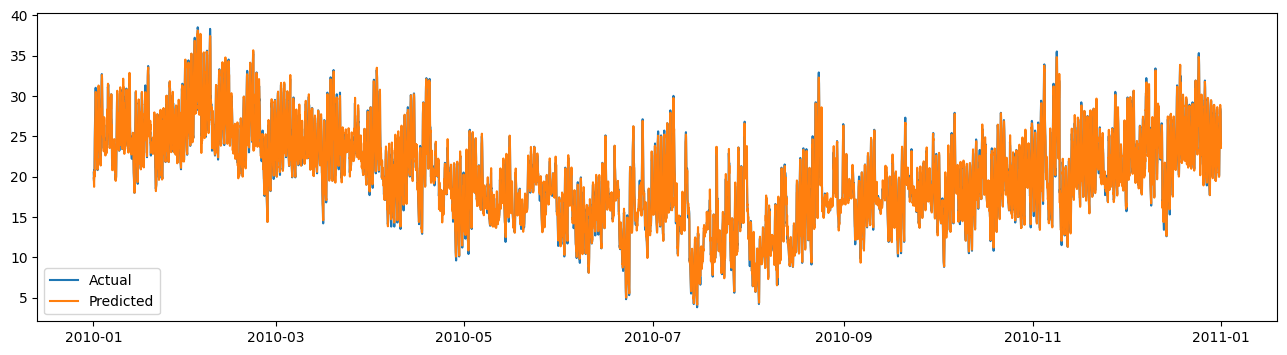

In [32]:
exog_temp = df_train.drop(columns=['TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)', 'lag_1', 'lag_2', 'lag_3'])
# for lag in lags:
model = ARIMA(df_train['TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)'], order=(1, 0, 1), seasonal_order=(1, 1, 1, 24), exog = df_train[['lag_1', 'lag_2']], enforce_invertibility=False, enforce_stationarity=False)
model_fit = model.fit()
previsao_treino = model_fit.predict(start=0, end=len(df_train)-1)
plt.figure(figsize=(16,4))
plt.plot(df_train['TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)'], label="Actual")
plt.plot(previsao_treino, label="Predicted")
plt.legend()


Como não houve diferença no treino, iremos utilizar o modelo com lag 1, que seria o mais abrangente

Ajustando o conjunto de validação

In [33]:
df_val.head()

,hora,mes,lag_1,lag_2,lag_3,TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C),fourier_1_sin,fourier_1_cos,fourier_2_sin,fourier_2_cos,fourier_3_sin,fourier_3_cos
DATETIME,,,,,,,,,,,,
2011-01-01 00:00:00,0,1,24.1,25.2,26.8,22.8,-3.665109e-13,1.000000,-7.330218e-13,1.000000e+00,-6.447853e-13,1.000000e+00
2011-01-01 01:00:00,1,1,22.8,24.1,25.2,22.3,2.588190e-01,0.965926,5.000000e-01,8.660254e-01,7.071068e-01,7.071068e-01
2011-01-01 02:00:00,2,1,22.3,22.8,24.1,21.7,5.000000e-01,0.866025,8.660254e-01,5.000000e-01,1.000000e+00,4.796453e-13
2011-01-01 03:00:00,3,1,21.7,22.3,22.8,21.4,7.071068e-01,0.707107,1.000000e+00,-3.416129e-13,7.071068e-01,-7.071068e-01
2011-01-01 04:00:00,4,1,21.4,21.7,22.3,21.2,8.660254e-01,0.500000,8.660254e-01,-5.000000e-01,-5.949893e-13,-1.000000e+00


Prevendo no conjunto de validação

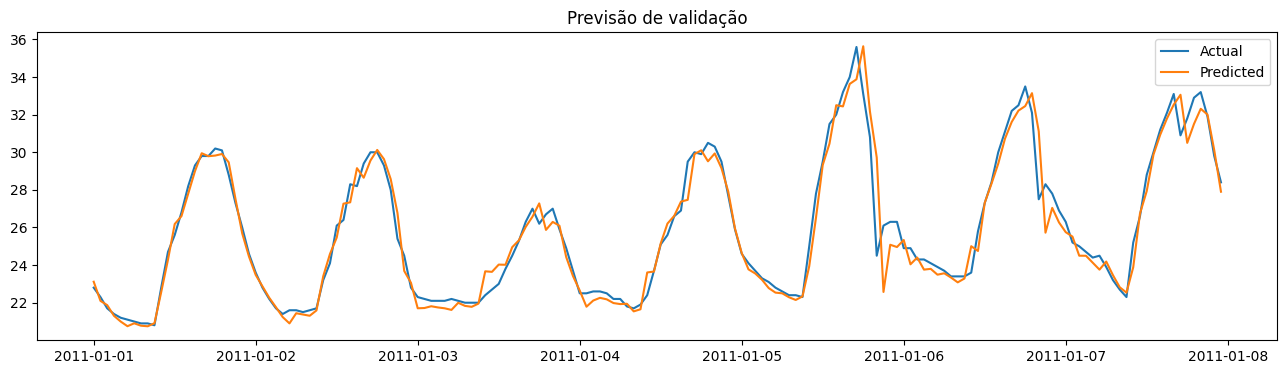

In [20]:
previsao_val = model_fit.predict(start=len(df_train), end=(len(df_train) + len(df_val))-1, exog=df_val[['lag_1', 'lag_2']])
plt.figure(figsize=(16,4))
plt.plot(df_val['TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)'].iloc[:168], label="Actual")
plt.plot(previsao_val.iloc[:168], label="Predicted")
plt.title(f"Previsão de validação")
plt.legend()

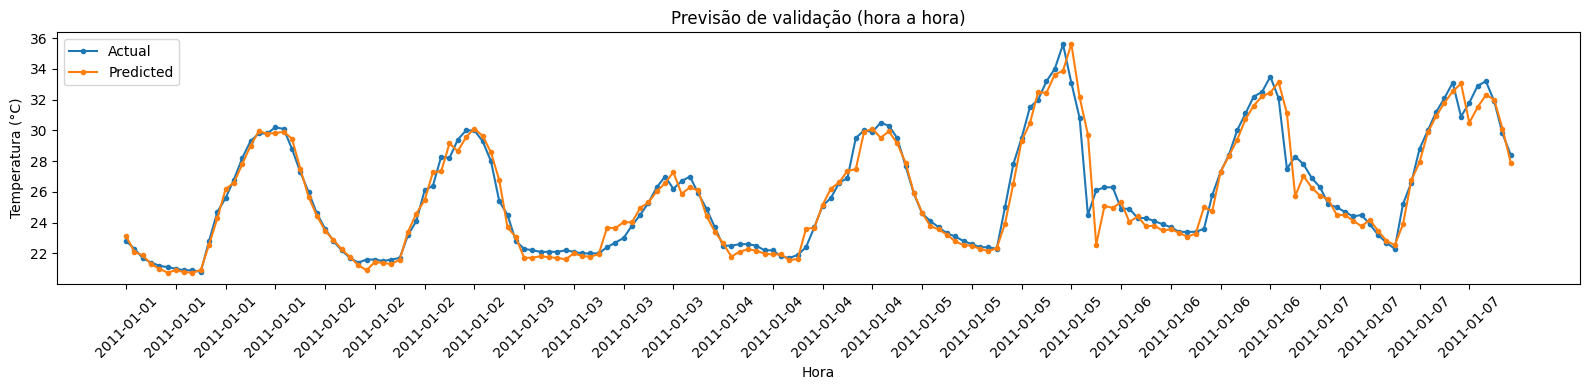

In [21]:
n = 168

plt.figure(figsize=(16,4))

plt.plot(
    df_val.index[:n],
    df_val['TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)'].iloc[:n],
    label="Actual",
    marker='o',
    markersize=3
)

plt.plot(
    df_val.index[:n],
    previsao_val.iloc[:n],
    label="Predicted",
    marker='o',
    markersize=3
)

plt.title("Previsão de validação (hora a hora)")
plt.xlabel("Hora")
plt.ylabel("Temperatura (°C)")
plt.legend()

# Mostra uma marca a cada 6 horas (ajuste se quiser)
plt.xticks(df_val.index[:n:6], rotation=45)

plt.tight_layout()
plt.show()


In [22]:
from sklearn.metrics import mean_squared_error
print(np.sqrt(mean_squared_error(df_val['TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)'], previsao_val)))

0.8216698474189973


In [23]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                           SARIMAX Results                                            
======================================================================================================
Dep. Variable:     TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)   No. Observations:                 8757
Model:                           ARIMA(1, 0, 1)x(1, 1, 1, 24)   Log Likelihood               -9125.135
Date:                                        Tue, 16 Dec 2025   AIC                          18264.271
Time:                                                13:00:02   BIC                          18313.774
Sample:                                            01-01-2010   HQIC                         18281.143
                                                 - 12-31-2010                                         
Covariance Type:                                          opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
lag_1          1.1258      0.083     13.602      0.000       0.964       1.288
lag_2         -0.1723      0.080     -2.149      0.032      -0.329      -0.015
ar.L1          0.5758      0.144      4.001      0.000       0.294       0.858
ma.L1         -0.4412      0.221     -1.993      0.046      -0.875      -0.007
ar.S.L24       0.0800      0.009      9.066      0.000       0.063       0.097
ma.S.L24      -0.9492      0.003   -308.428      0.000      -0.955      -0.943
sigma2         0.4733      0.003    166.011      0.000       0.468       0.479
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):             73600.18
Prob(Q):                              0.87   Prob(JB):                         0.00
Heteroskedasticity (H):               0.93   Skew:                            -0.89
Prob(H) (two-sided):                  0.05   Kurtosis:                        17.13
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Avaliação no conjunto de teste


In [37]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

In [40]:
# Selecionar a primeira linha do df_test como exógena
exog_test_1step = df_test[['lag_1', 'lag_2']].iloc[[0]]  # manter como DataFrame

# Previsão 1-step
y_pred_test = model_fit.get_forecast(steps=1, exog=exog_test_1step).predicted_mean

# Valor real
y_true_test = df_test['TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)'].iloc[[0]]

# Transformar em arrays para compatibilidade com sklearn
y_pred_arr = np.atleast_1d(y_pred_test.values)
y_true_arr = np.atleast_1d(y_true_test.values)

# --- Cálculo de métricas ---
rmse_1step = np.sqrt(mean_squared_error(y_true_arr, y_pred_arr))
mae_1step = mean_absolute_error(y_true_arr, y_pred_arr)

# MAPE pode lançar erro/dividir por zero
try:
    mape_1step = mean_absolute_percentage_error(y_true_arr, y_pred_arr) * 100
except Exception:
    mape_1step = float('nan')

# --- Exibir métricas ---
print("\n=== MÉTRICAS 1-step (Teste) ===")
print(f"RMSE (1-step): {rmse_1step:.4f}")
print(f"MAE (1-step): {mae_1step:.4f}")
if np.isfinite(mape_1step):
    print(f"MAPE (1-step): {mape_1step:.2f}%")
else:
    print("MAPE (1-step): N/A")

# --- Valores individuais ---
print(f"\nÍndice previsto: {df_test.index[0]}")
print(f"Valor real: {y_true_arr[0]:.3f}")
print(f"Valor previsto (1-step): {y_pred_arr[0]:.3f}")


=== MÉTRICAS 1-step (Teste) ===
RMSE (1-step): 0.4822
MAE (1-step): 0.4822
MAPE (1-step): 2.66%

Índice previsto: 2012-01-01 00:00:00
Valor real: 18.100
Valor previsto (1-step): 18.582
